## 0.0 Imports

In [4]:
import numpy as np  
import pandas as pd  
import datetime as dt  
import warnings  

import matplotlib.pyplot as plt  
import seaborn as sns  

# Statsmodels  
import statsmodels.api as sm  
from statsmodels.tsa.stattools import adfuller, acf  
from statsmodels.tsa.statespace.sarimax import SARIMAX  
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.graphics.tsaplots import plot_acf  
from statsmodels.graphics.tsaplots import plot_pacf

# PMDARIMA  
from pmdarima import auto_arima  

# Scikit-learn  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error  

# Facebook Prophet  
from prophet import Prophet  

# Supressão de warnings  
warnings.filterwarnings("ignore")

## 1.0 Extração e Tratamento dos dados

In [5]:
df_base_ipea = pd.read_csv('Base_IPEA.csv',delimiter=';')

In [6]:
df_base_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11333 entries, 0 to 11332
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Data            11333 non-null  object
 1   Valor_Petroleo  11333 non-null  object
dtypes: object(2)
memory usage: 177.2+ KB


In [7]:
df_base_ipea.rename(columns={'Data':'data','Valor_Petroleo':'preco'},inplace=True)

In [8]:
df_base_ipea['data'] = pd.to_datetime(df_base_ipea['data'], format='%d/%m/%Y')
df_base_ipea['preco'] = df_base_ipea['preco'].str.replace(',','.').astype('float')

In [9]:
df_base_ipea.isnull().sum()

data     0
preco    0
dtype: int64

In [10]:
df_base_ipea.duplicated().sum()

0

In [11]:
df_base_ipea.shape

(11333, 2)

In [12]:
df_base_ipea.head()

,data,preco
0,2025-01-06,77.27
1,2025-01-03,76.72
2,2025-01-02,76.14
3,2024-12-31,74.58
4,2024-12-30,74.24


In [13]:
df_base_ipea['data'].min()

Timestamp('1987-05-20 00:00:00')

In [14]:
df_base_ipea['data'].max()

Timestamp('2025-01-06 00:00:00')

In [15]:
df_base_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11333 entries, 0 to 11332
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11333 non-null  datetime64[ns]
 1   preco   11333 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 177.2 KB


## 2.0 Analise Descritiva dos dados

In [16]:
df_base_ipea['preco'].describe().round(2)

count    11333.00
mean        53.39
std         33.13
min          9.10
25%         20.65
50%         49.08
75%         76.74
max        143.95
Name: preco, dtype: float64

In [17]:
media = df_base_ipea['preco'].mean()
mediana = df_base_ipea['preco'].median()
desvio_padrao = df_base_ipea['preco'].std()
minimo = df_base_ipea['preco'].min()
maximo = df_base_ipea['preco'].max()

Podemos observar que os valores variam de 9,10 a 143,95 dólares, com uma média de 53,39 dólares. 


In [18]:
print(f"Valor Mínimo do Preço: {minimo}")
print(f"Valor Máximo do Preço: {maximo}")
print(f"Média do Preço: {media}")

Valor Mínimo do Preço: 9.1
Valor Máximo do Preço: 143.95
Média do Preço: 53.38783552457425


O desvio padrão alto 33,13 sugere grande volatilidade, ou seja, os preços oscilaram bastante ao longo do tempo, o que é justificavel, pois nossa base contém informações desde 1987.

In [19]:
print(f"Desvio Padrão do Preço: {desvio_padrao}")

Desvio Padrão do Preço: 33.12864792853254


O fato de a mediana (49,08) ser menor que a média (53,39) sugere que alguns valores altos extremos influenciam a média.

In [20]:
print(f"Média do Preço: {media}")
print(f"Mediana do Preço: {mediana}")

Média do Preço: 53.38783552457425
Mediana do Preço: 49.08


Análise de Skewness e Kurtosis para o Preço do Petróleo

 1. **Skewness (Assimetria)**: **0.512**
Temos uma **assimetria positiva leve (0.512)**, o que indica que a distribuição tem uma cauda mais longa à direita. Isso significa que existem alguns valores de preços do petróleo excepcionalmente altos, mas eles não são tão frequentes.
---

 2. **Kurtosis (Curtose)**: **-0.926**
Com uma **curtose negativa (-0.926)**, a distribuição é **platicúrtica**, ou seja, possui caudas mais leves do que uma distribuição normal. Isso indica que eventos extremos, como preços muito altos ou muito baixos, são menos frequentes.


In [21]:
assimetria = df_base_ipea['preco'].skew()
curtose = df_base_ipea['preco'].kurt()

print(f"Assimetria do Preço: {assimetria}")
print(f"Curtose do Preço: {curtose}")

Assimetria do Preço: 0.5120298228978719
Curtose do Preço: -0.9259474817004865


 **Histograma do Preço**
O histograma mostra a distribuição da frequência dos preços do petróleo ao longo dos intervalos de valores.
A maior parte dos preços está concentrada nos valores mais baixos (20 a 40), com a frequência diminuindo gradualmente à medida que o preço aumenta.
Há uma cauda mais longa à direita, indicando a presença de valores de preço mais altos, embora sejam menos frequentes.
Essa característica reflete a assimetria positiva da distribuição, conforme já indicado pelo valor de skewness (0.512).

 **Boxplot dos Valores de Preço**
O boxplot fornece uma visão resumida da dispersão dos preços do petróleo.
A mediana (linha no meio da caixa) está próxima do centro, indicando que metade dos valores está abaixo dela e metade acima.
Os bigodes mostram que os preços variam dentro de um intervalo sem muitos outliers extremos, o que está em concordância com a curtose negativa (-0.926), indicando caudas mais leves.
A distribuição de preços está concentrada em valores menores, reforçando o padrão visualizado no histograma.

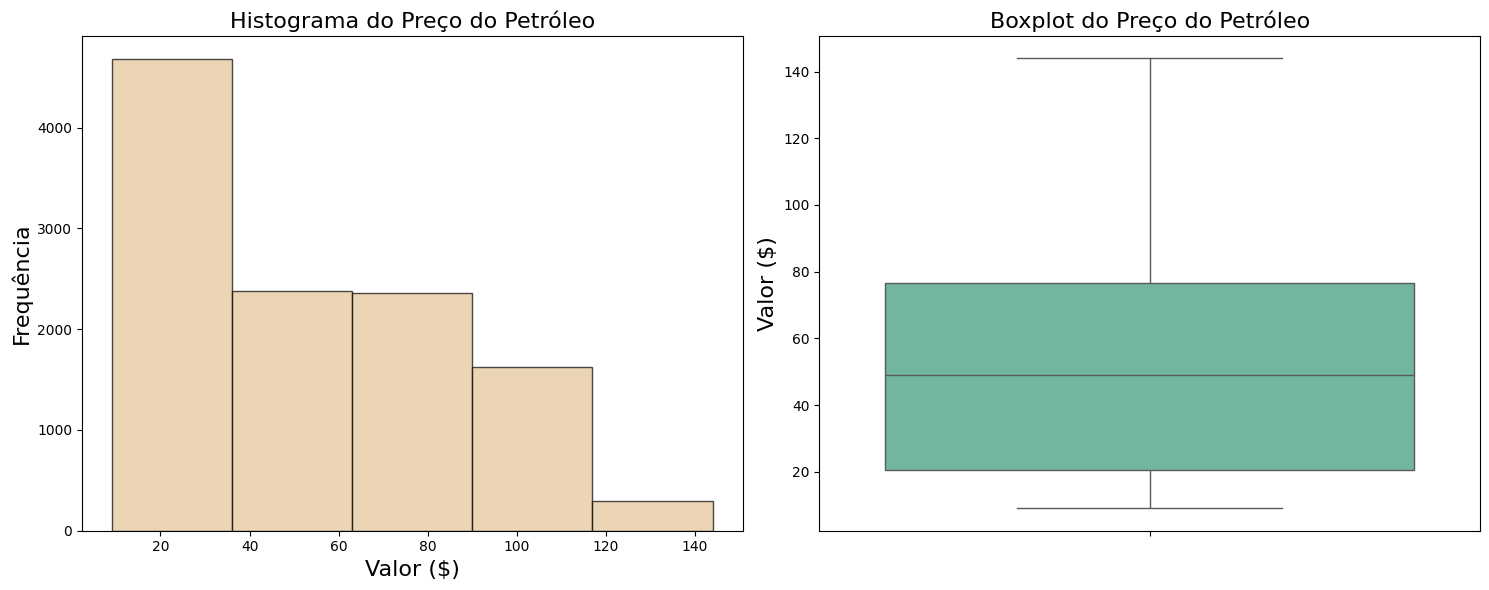

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
medium_colors = sns.color_palette("Set2")

# Histograma
axes[0].hist(df_base_ipea['preco'], bins=5, color=medium_colors[6], edgecolor='black', alpha=0.7)
axes[0].set_title('Histograma do Preço do Petróleo', fontsize=16)
axes[0].set_xlabel('Valor ($)', fontsize=16)
axes[0].set_ylabel('Frequência', fontsize=16)

# Boxplot
sns.boxplot(y='preco', data=df_base_ipea, color=medium_colors[0], ax=axes[1])
axes[1].set_title('Boxplot do Preço do Petróleo', fontsize=16)
axes[1].set_ylabel('Valor ($)', fontsize=16)

plt.tight_layout()
plt.show()


No gráfico de linhas, podemos observar que, de maneira geral, os valores do Preço apresentam uma alta volatilidade, com várias oscilações ao longo do período.

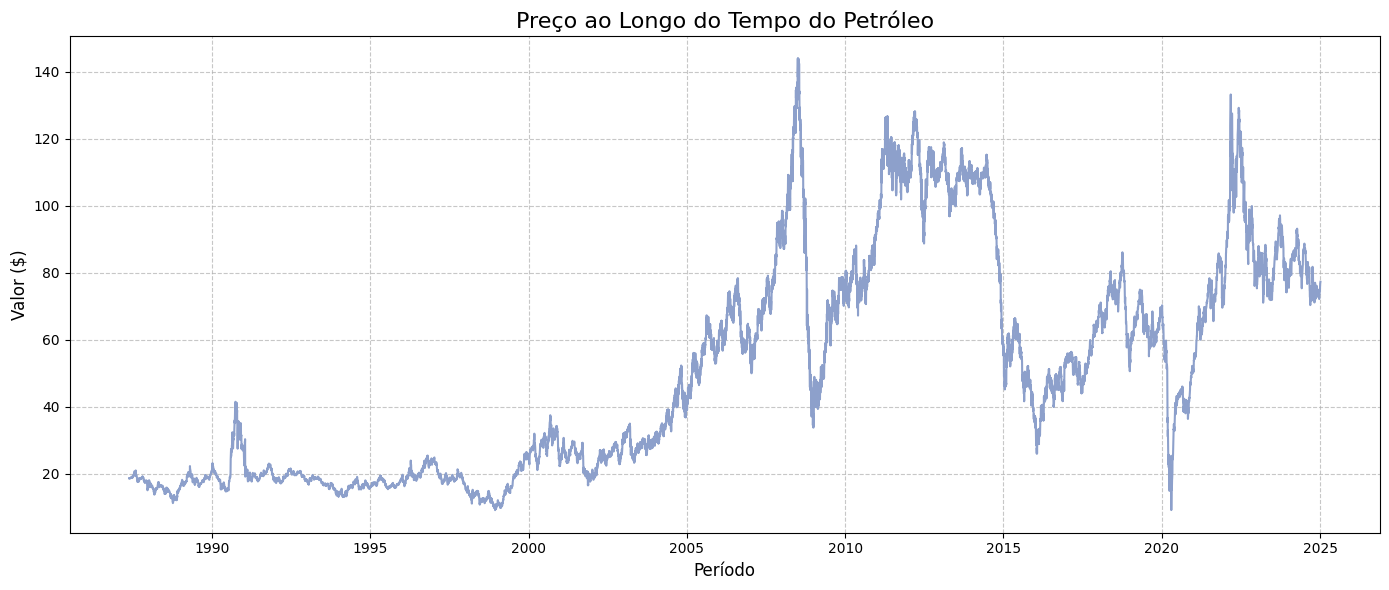

In [23]:
plt.figure(figsize=(14,6)) 
medium_colors = sns.color_palette("Set2")

sns.lineplot(x='data', y='preco', color=medium_colors[2], data=df_base_ipea)

plt.title('Preço ao Longo do Tempo do Petróleo', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor ($)', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 3.0 Preparações para o Modelo

In [24]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

In [25]:
df_base_ipea.set_index('data',inplace=True)
df_base_ipea.sort_index(ascending=True,inplace=True)

**Nos gráficos gerados pela função seasonal_decompose, podemos realizar diversas análises:**

O primeiro gráfico apresenta os dados brutos, onde podemos observar a volatilidade presente. 
No segundo gráfico, observamos a tendência estimada, que é muito semelhante à série original, indicando que a maior parte da variação nos preços do petróleo é explicada por movimentos de longo prazo.
O terceiro gráfico revela a sazonalidade, onde mostrou valores praticamente nulos, indicando que não há padrões sazonais claros. Assim, a maior parte da série é atribuída à tendência, deixando a série original e a tendência muito similares.
Por fim, o último gráfico ilustra os ruídos dos dados, representando as flutuações aleatórias que não são capturadas pela tendência ou pela sazonalidade.

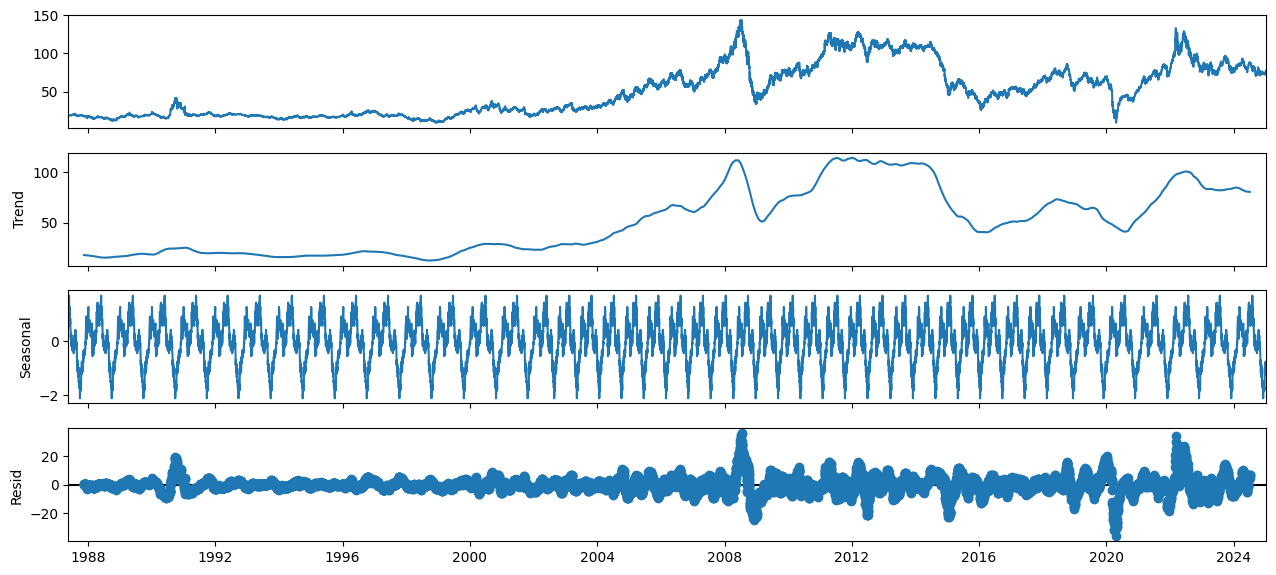

In [26]:
result = seasonal_decompose(df_base_ipea, model="additive", period=255)
fig = result.plot()
fig.set_size_inches(14, 6)

Ao plotarmos um gráfico com uma média movel simples de 30 dias, podemos ver que a tendência dos dados não se altera muito comparada ao valor original, isso só comprova que a base que estamos lidando tem uma alta volatilidade, o que pode nos atrapalhar na hora de selecionarmos um modelo.

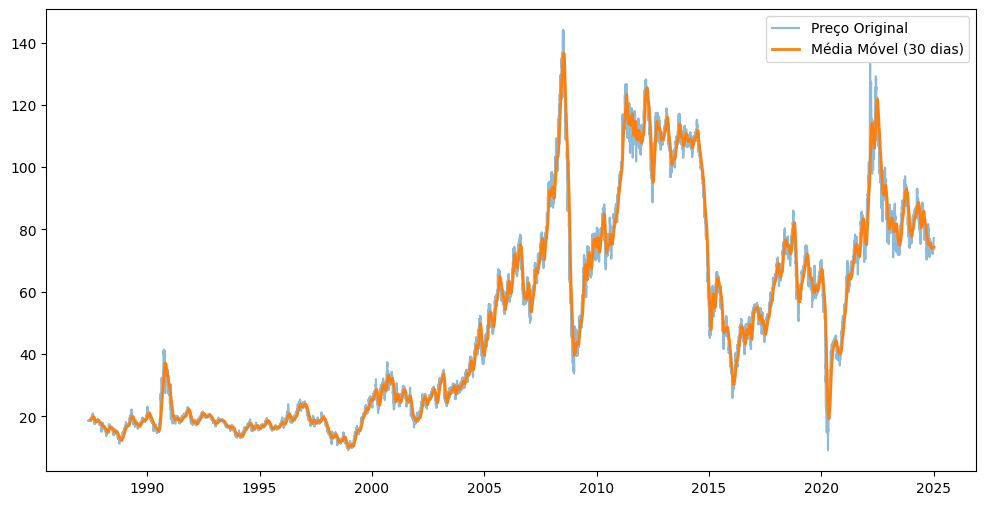

In [27]:
df_media_movel = df_base_ipea
df_media_movel['media_movel'] = df_media_movel['preco'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_media_movel['preco'], label='Preço Original', alpha=0.5)
plt.plot(df_media_movel['media_movel'], label='Média Móvel (30 dias)', linewidth=2)
plt.legend()
plt.show()

In [28]:
def plot_acf_custom(data, lags=250, title="Autocorrelação da Série Temporal"):
    fig, ax = plt.subplots(figsize=(15, 5))
    
    plot_acf(data, lags=lags, ax=ax, alpha=0.05)  
    
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.tight_layout()  

    acf_x = acf(data, nlags=lags, alpha=0.05)
    acf_values, ci = acf_x[:2]

    intercept_point = np.where(abs(acf_values) < (ci[:, 1] - acf_values))
    
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da ACF interceptam o limite no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da ACF não interceptam o limite")

O gráfico ACF mostra uma autocorrelação alta e decrescente à medida que os lags aumentam, mas os valores permanecem fora do intervalo azul de confiança por muitos lags. Isso indica uma forte dependência temporal nos dados, sugerindo que a série não é estacionária e possui uma tendência de longo prazo. Essa informação é útil para nosso modelo, pois ele irá nos ajudar a definir o valor de "Q" no ARIMA

Os coeficientes da ACF não interceptam o limite


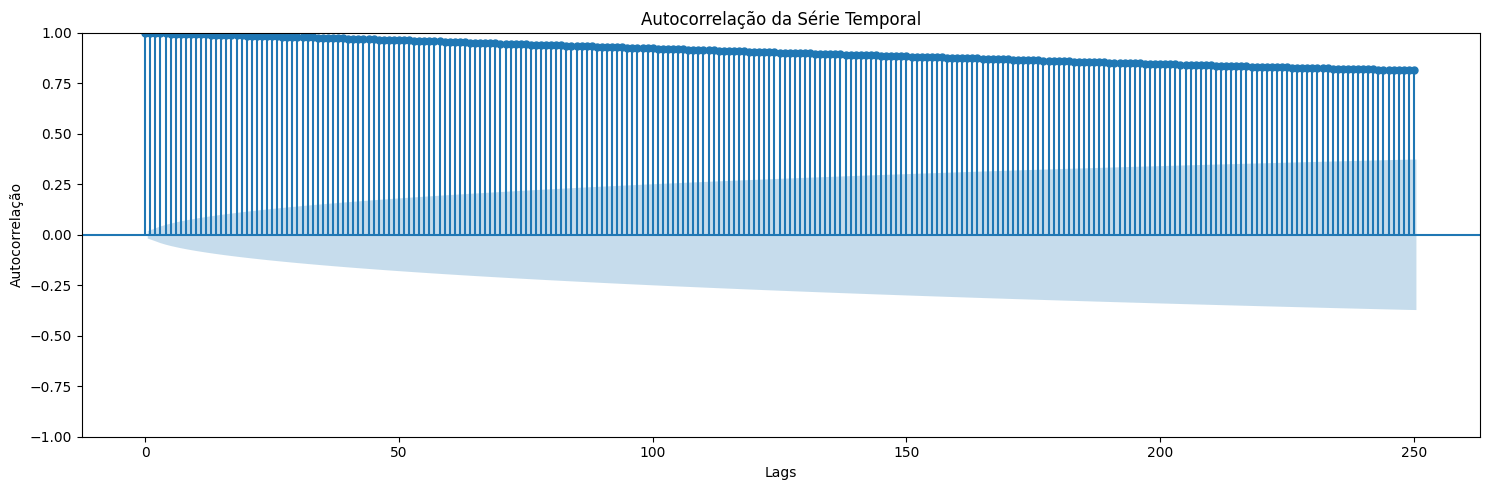

In [29]:
plot_acf_custom(df_base_ipea["preco"],250)

In [30]:
def plot_pacf_custom(data, lags=50, title="Autocorrelação Parcial da Série Temporal"):
    fig, ax = plt.subplots(figsize=(15, 5))

    plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.tight_layout()
    
    pacf_values, confidence_intervals = sm.tsa.stattools.pacf(data, alpha=0.05, nlags=lags)[:2]
    
    intercept_point = np.where(abs(pacf_values) < (confidence_intervals[:, 1] - pacf_values))
    
    if intercept_point[0].size > 0:
        print(f"Os coeficientes do PACF interceptam o limiar no lag {intercept_point[0][0]}")
    else:
        print("Os coeficientes do PACF não interceptam o limiar de confiança.")
    
    plt.show()


No gráfico **PACF**, vemos que os primeiros dois lags têm valores altos e significativos (acima do intervalo azul de confiança). Isso indica que os valores da série estão fortemente relacionados com as duas primeiras defasagens, com isso podemos definir nosso valor de "P" para ajustarmos o modelo ARIMA e SARIMA.

Os coeficientes do PACF interceptam o limiar no lag 6


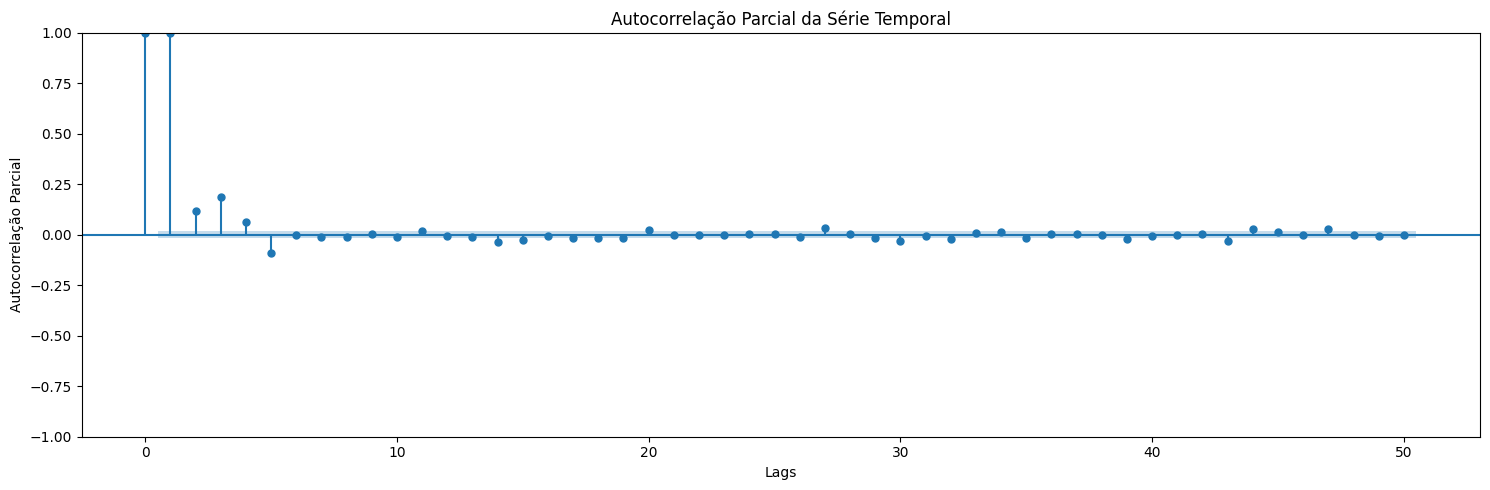

In [31]:
plot_pacf_custom(df_base_ipea["preco"])

Aqui efetuamos um teste para sabermos se nossa base é estácionaria ou não, e tivemos a conclusão que ela não é estacionária, ou seja, ela possui uma tendencia presente nos dados, isso pode atrapalhar nosso modelo, pois ele pode se adaptar mal, o que pode ocasionar uma má performance dele. 

In [32]:
adf_result = sm.tsa.adfuller(df_base_ipea["preco"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -2.117686927195462
p-value: 0.23746232844159892
Critical Values: {'1%': -3.430928779398039, '5%': -2.8617957893080814, '10%': -2.566906151540755}
A série temporal não é estacionária


Aplicando uma diferenciação, conseguimos transformar nossa base em estacionária, o que nos ajuda a definir o valor de "D" em nosso modelo, que será a quantidade de diferenciações necessárias para o modelo aplicar.

In [33]:
adf_result = sm.tsa.adfuller(df_base_ipea["preco"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -17.47556772236289
p-value: 4.518289237794213e-30
Critical Values: {'1%': -3.430928779398039, '5%': -2.8617957893080814, '10%': -2.566906151540755}
A série temporal é estacionária


Aqui utilizamos as funções de PACF,ACF e DIFERENCIAÇÃO para definirmos nossos valores de (P,Q,D)

In [34]:
acf_x = sm.tsa.acf(df_base_ipea["preco"], alpha=0.05, nlags=250)
acf, ci = acf_x[:2]

indices_q = np.where(abs(acf) > ci[:, 1])[0]
if len(indices_q) > 0:
    q = indices_q[0]
else:
    q = 1  

pacf_x = sm.tsa.pacf(df_base_ipea["preco"], alpha=0.05, nlags=50)
pacf, ci = pacf_x[:2]

indices_p = np.where(abs(pacf) > ci[:, 1])[0]
if len(indices_p) > 0:
    p = indices_p[0]
else:
    p = None  

d = 1  


In [35]:
print(F"Valor de P: {p}")
print(F"Valor de D: {d}")
print(F"Valor de P: {q}")

Valor de P: 5
Valor de D: 1
Valor de P: 1


Nessa parte utilizamos a função auto_arima para termos certeza que a melhor opção para colocarmos em nosso modelo é as que definimos logo acima, e tivemos a conclusão que ela está certa.

In [36]:
model_auto = auto_arima(df_base_ipea["preco"],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,             # O auto_arima determina o valor de 'd'
                        seasonal=False,     # Como não queremos o SARIMA aqui
                        trace=True,         # Para ver o progresso do ajuste
                        error_action='ignore', 
                        suppress_warnings=True,
                        stepwise=True)      # Stepwise faz o processo de seleção ser mais rápido

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40648.718, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40470.350, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40356.456, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40646.861, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40191.361, Time=1.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39979.709, Time=1.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40008.635, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=39888.920, Time=4.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39949.190, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=39850.606, Time=5.32 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=39848.848, Time=1.02 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39850.685, Time=1.27 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=39840.328, Time=13.49 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=39841.743, Time=14.83 sec
 ARIMA(4,1,2)(0,0

## 4.0 MODELOS

**MODELO ARIMA**

Como primeiro teste utilizamos o modelo ARIMA para analisar como nossas previsões se comportam. Este modelo pode não ser a melhor escolha para nossos dados devido à alta volatilidade, que introduz muitos ruídos, conforme observado na decomposição sazonal. Esses ruídos podem interferir negativamente no desempenho do modelo.

Decidimos utilizar apenas os dados dos últimos 15 anos para construir o modelo, pois acreditamos que valores mais recentes podem reduzir o ruído e melhorar a precisão das previsões.

In [37]:
df_base_ipea.dropna(subset=["preco"], inplace=True)

df_base_ipea.reset_index(inplace=True)

y = df_base_ipea[df_base_ipea['data'] >= '2010-01-01']['preco']


In [38]:
y_train = y.iloc[:-90]  
y_test = y.iloc[-90:]  


In [39]:
print(f"Tamanho do treino: {len(y_train)}")
print(f"Tamanho do teste: {len(y_test)}")

Tamanho do treino: 4659
Tamanho do teste: 90


In [40]:
model = sm.tsa.ARIMA(y_train, order=(p, d, q))
arima_model = model.fit()

preds_arima = arima_model.forecast(steps=len(y_test))

Após o treinamento com os dados, verificamos que as previsões do modelo para os próximos 90 dias apresentaram uma precisão moderada, com métricas como:

In [41]:
metrics_arima = calculate_metrics(y_test, preds_arima)
print("ARIMA Metrics:")
print_metrics(metrics_arima)


ARIMA Metrics:
MAE: 6.411014084329865
MSE: 45.88862114528868
MAPE: 8.67 %


Avaliamos que a dificuldade do modelo ARIMA em capturar tendências claras se deve à alta volatilidade e ao ruído presente nos dados, apesar de haver alguma autocorrelação. A elevada volatilidade torna difícil para o modelo distinguir entre o sinal verdadeiro (tendência) e o ruído aleatório. Mesmo com métricas de MAPE apresentando bons resultados, observamos que o modelo não consegue se adaptar adequadamente às previsões, resultando em um falso resultado positivo. Isso sugere que a complexidade e a natureza ruidosa da nossa base de dados superam a capacidade do modelo ARIMA de fornecer previsões precisas e confiáveis.

Essa situação também afeta a componente de Média Móvel (MA) do modelo. Como o MA depende dos erros passados para ajustar as previsões futuras, capturar valores aleatórios em vez de padrões significativos pode comprometer ainda mais a precisão das previsões.

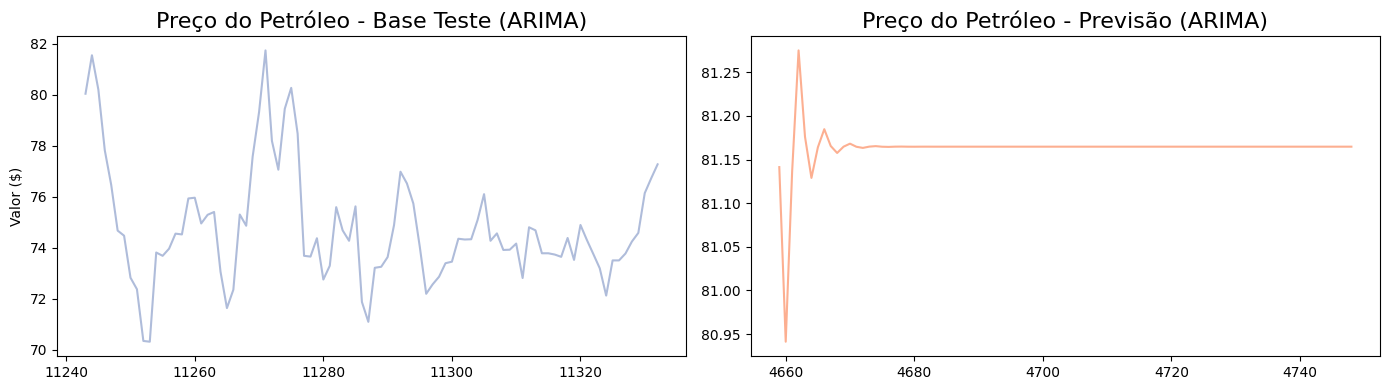

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
medium_colors = sns.color_palette("Set2")

axes[0].plot(y_test, color=medium_colors[2], alpha=0.7)
axes[0].set_title('Preço do Petróleo - Base Teste (ARIMA)', fontsize=16)
axes[0].set_ylabel('Valor ($)')

axes[1].plot(preds_arima, color=medium_colors[1], alpha=0.7)
axes[1].set_title('Preço do Petróleo - Previsão (ARIMA)', fontsize=16)

plt.tight_layout()
plt.show()


**MODELO SARIMA**

Vamos testar agora o modelo **SARIMA** que seria o modelo ARIMA, porém com o componente de sazonalidade adicionado, para tentarmos capturar algum padrão nos dados, porém vimos anteriormente que nossa base tem uma sazonalidade baixa, o que pode atrapalhar nesse modelo.

Utilizamos o auto_arima para identificar os melhores parâmetros (P, Q, D) para o nosso modelo. A ferramenta auto_arima automatiza o processo de seleção de parâmetros, utilizando critérios de informação como AIC (Akaike Information Criterion) e BIC (Bayesian Information Criterion) para avaliar diferentes combinações e escolher a que melhor se adapta aos dados. Isso ajuda a evitar overfitting, pois penaliza a complexidade do modelo e favorece a simplicidade.

Ao definir a sazonalidade com m = 5, estamos considerando um padrão sazonal que se repete semanalmente nos dias úteis (segunda a sexta). O método stepwise agiliza o processo de busca, testando iterativamente diferentes combinações de parâmetros e selecionando o modelo mais adequado.

In [43]:
model_auto = auto_arima(df_base_ipea["preco"],
                         seasonal=True,    
                         m=5,            
                         trace=True,      
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)    

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=39890.874, Time=15.48 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=40648.718, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=40472.250, Time=0.84 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=40358.202, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=40646.861, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=39891.699, Time=4.87 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=39892.385, Time=3.99 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=39889.956, Time=17.80 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=39888.389, Time=13.42 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=40059.560, Time=3.84 sec
 ARIMA(2,1,1)(2,0,0)[5] intercept   : AIC=39979.919, Time=5.04 sec
 ARIMA(3,1,2)(2,0,0)[5] intercept   : AIC=39846.347, Time=11.97 sec
 ARIMA(3,1,2)(1,0,0)[5] intercept   : AIC=39850.108, Time=7.54 sec
 ARIMA(3,1,2)(2,0,1)[5] intercept   : AIC=39847.302, Time=17.30 sec
 ARIMA(3,1,2)(

In [44]:
p = 3  # AR regular
d = 1  # Diferença regular
q = 2  # MA regular

P = 1  # AR sazonal
D = 0  # Diferença sazonal
Q = 1  # MA sazonal
S = 5 # Sazonalidade 


model = sm.tsa.SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_model = model.fit()

preds_sarima = sarima_model.forecast(steps=len(y_test))

In [45]:
metrics_sarima = calculate_metrics(y_test, preds_sarima)
print("SARIMA Metrics:")
print_metrics(metrics_sarima)


SARIMA Metrics:
MAE: 6.38820182094798
MSE: 45.58224585523699
MAPE: 8.64 %


Mesmo com a adição da sazonalidade semanal no modelo SARIMA, nossas previsões ainda enfrentaram dificuldades. Observamos que a sazonalidade é quase imperceptível nos dados e os níveis de ruído permanecem elevados. O que faz nos ter uma falsa impressão que o modelo está bem ajustado com as métricas.

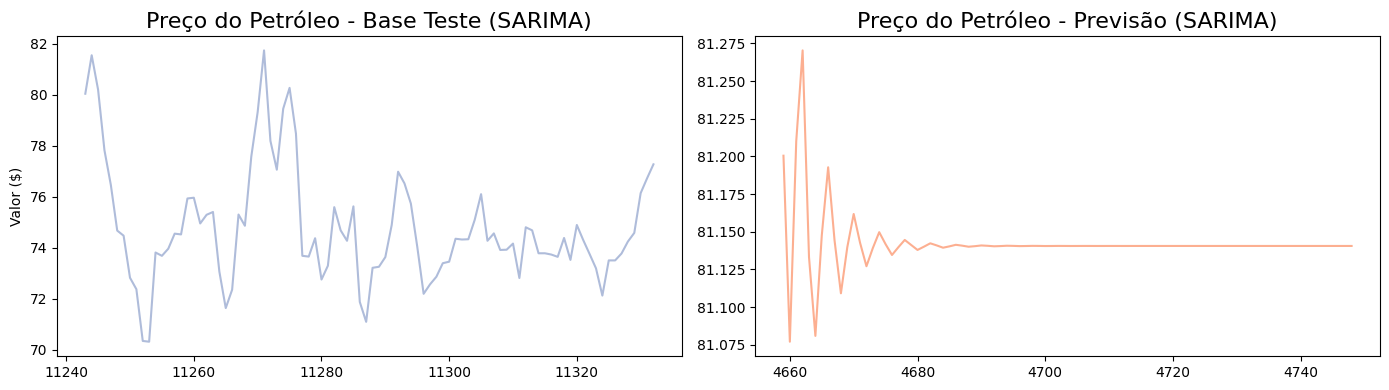

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
medium_colors = sns.color_palette("Set2")

axes[0].plot(y_test, color=medium_colors[2], alpha=0.7)
axes[0].set_title('Preço do Petróleo - Base Teste (SARIMA)', fontsize=16)
axes[0].set_ylabel('Valor ($)')

axes[1].plot(preds_sarima, color=medium_colors[1], alpha=0.7)
axes[1].set_title('Preço do Petróleo - Previsão (SARIMA)', fontsize=16)

plt.tight_layout()
plt.show()


**MODELO SARIMAX**

Vamos utilizar agora o modelo **SARIMAX**, que é uma extensão do modelo SARIMA, mas com a adição de variáveis exógenas. Isso significa que, além de considerar os padrões sazonais e autoregressivos nos dados, o modelo também incluirá informações de variáveis externas (exógenas) para tentar identificar padrões adicionais e melhorar as previsões.

In [47]:
y = df_base_ipea[df_base_ipea['data'] >= '2010-01-01']

y.reset_index(inplace=True)

Criamos as variáveis exógenas DIA, MÊS e ANO para ajudar nosso modelo a ter uma melhor performance

In [48]:
y['ano'] = y['data'].dt.year
y['mes'] = y['data'].dt.month
y['dia'] = y['data'].dt.day

In [49]:
y_train = y.iloc[:-90]  
y_test = y.iloc[-90:]  

print(f"Tamanho do treino: {len(y_train)}")
print(f"Tamanho do teste: {len(y_test)}")

Tamanho do treino: 4659
Tamanho do teste: 90


In [50]:
exog_train = y_train[['ano','mes','dia']]
exog_test = y_test[['ano','mes','dia']]

model = sm.tsa.statespace.SARIMAX(
    y_train["preco"],
    exog=exog_train,
    order=(
        3,
        1,
        2,
    ),  
    seasonal_order=(1, 0, 1, 5),
)
results = model.fit()

preds_sarimax = results.get_forecast(steps=len(y_test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(y_test["preco"], preds_sarimax)

In [51]:
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 6.350455336986712
MSE: 45.12304741774568
MAPE: 8.59 %


Mesmo com a adição de variáveis exógenas, observamos que as previsões ainda enfrentam dificuldades devido à alta volatilidade e ao ruído presente nos dados. As boas métricas de MAPE sugerem que o modelo tem um desempenho razoável, mas a complexidade e a natureza ruidosa dos dados ainda apresentam desafios significativos para previsões altamente precisas. As variáveis exógenas ajudam a capturar alguns padrões externos, mas não são suficientes para compensar completamente a influência do ruído nos dados.

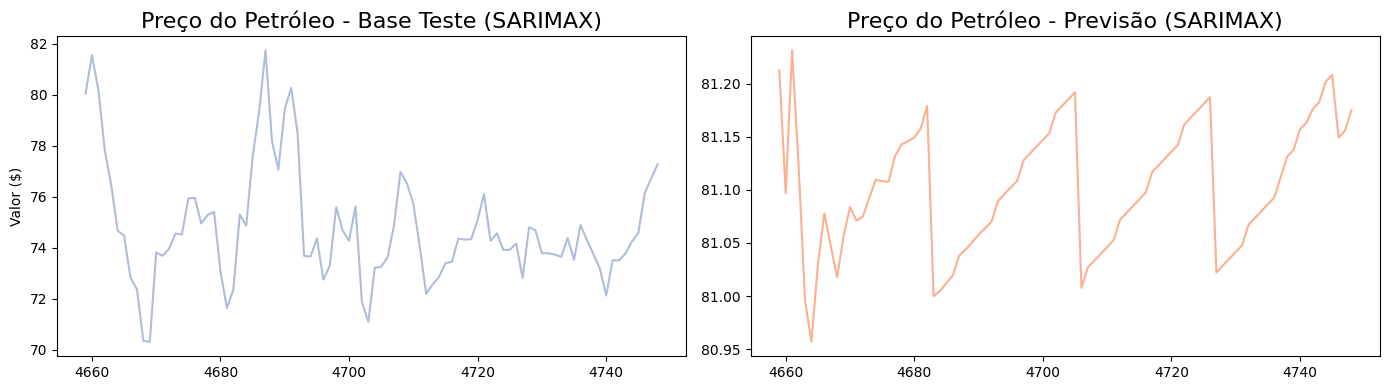

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
medium_colors = sns.color_palette("Set2")

axes[0].plot(y_test['preco'], color=medium_colors[2], alpha=0.7)
axes[0].set_title('Preço do Petróleo - Base Teste (SARIMAX)', fontsize=16)
axes[0].set_ylabel('Valor ($)')

axes[1].plot(preds_sarimax, color=medium_colors[1], alpha=0.7)
axes[1].set_title('Preço do Petróleo - Previsão (SARIMAX)', fontsize=16)

plt.tight_layout()
plt.show()


**PROPHET**

O Prophet é um modelo mais robusto para séries temporais, permitindo identificar sazonalidades complexas, incluindo feriados e eventos especiais. Isso possibilita um ajuste mais preciso das previsões, mesmo em dados com alta volatilidade e ruído. A flexibilidade do Prophet em modelar diferentes componentes sazonais e eventos específicos contribui para uma melhor performance e previsões mais confiáveis em nossa base de dados.

In [53]:
df_prophet = df_base_ipea.rename(columns={'data': 'ds', 'preco': 'y'})
df_prophet = df_prophet[['ds','y']]
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet[df_prophet['ds'] >= '2010-01-01']

In [54]:
df_prophet['ano'] = df_prophet['ds'].dt.year
df_prophet['mes'] = df_prophet['ds'].dt.month
df_prophet['dia'] = df_prophet['ds'].dt.day
df_prophet['dia_semana'] = df_prophet['ds'].dt.weekday 

In [55]:
df_prophet = df_prophet[['ds', 'y', 'ano', 'mes', 'dia', 'dia_semana']]

No gráfico abaixo podemos observar as seguintes informações, na linha com a cor preta temos os valores reais da base, na linha azul temos as previsões do modelo e na margem azul temos o intervalo de confiança dos dados, onde possivelmente eles se encontram.

22:14:59 - cmdstanpy - INFO - Chain [1] start processing
22:15:02 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet')

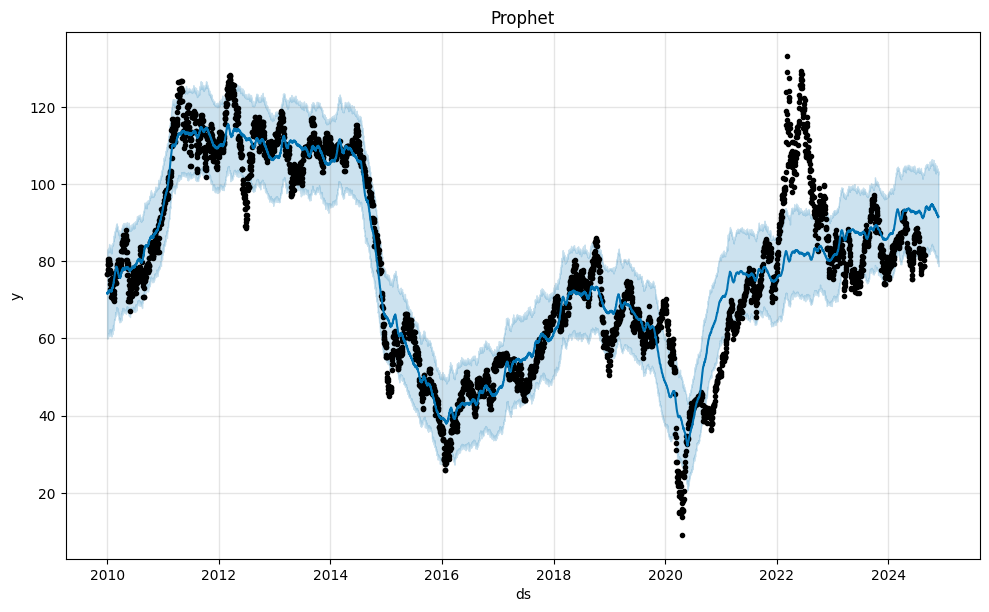

In [56]:
df_train = df_prophet.iloc[:-90]  
df_test = df_prophet.iloc[-90:]  

model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1  
)
model.add_regressor('ano')
model.add_regressor('mes')
model.add_regressor('dia')
model.add_regressor('dia_semana')

model.fit(df_train)

future = model.make_future_dataframe(periods=90)

future['ano'] = future['ds'].dt.year
future['mes'] = future['ds'].dt.month
future['dia'] = future['ds'].dt.day
future['dia_semana'] = future['ds'].dt.weekday

forecast_test = model.predict(future)


model.plot(forecast_test)
plt.title("Prophet")


In [57]:
predictions = forecast_test.iloc[-90:]['yhat']
metrics = calculate_metrics(df_test['y'], predictions)
print("Prophet Metrics:")
print_metrics(metrics)

Prophet Metrics:
MAE: 18.72835080193185
MSE: 357.2870035692003
MAPE: 25.16 %


Apesar das métricas de erro mais altas, o Prophet foi mais eficaz ao ajustar os valores, proporcionando previsões mais realistas e sensíveis às mudanças no comportamento do mercado, o que o torna mais adequado para esse tipo de previsão.

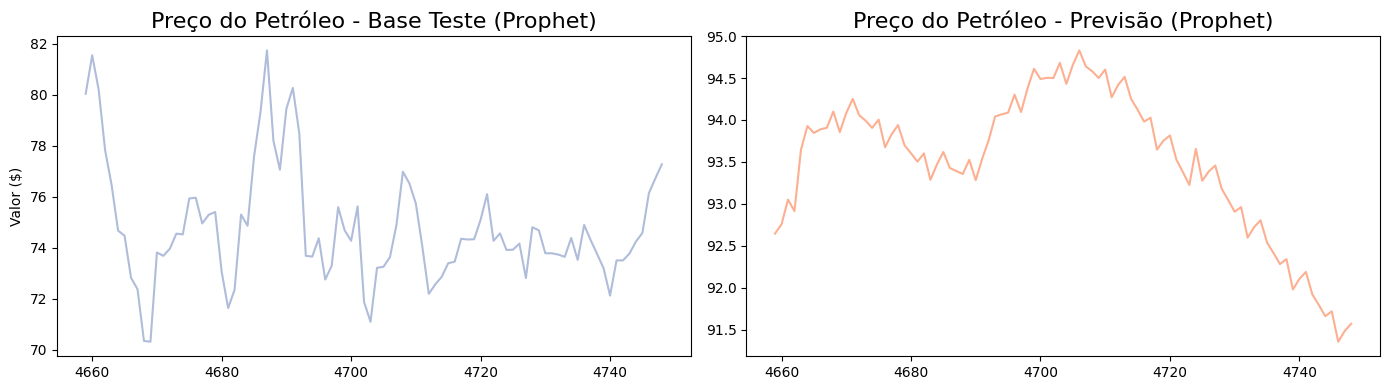

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
medium_colors = sns.color_palette("Set2")

axes[0].plot(y_test['preco'], color=medium_colors[2], alpha=0.7)
axes[0].set_title('Preço do Petróleo - Base Teste (Prophet)', fontsize=16)
axes[0].set_ylabel('Valor ($)')

axes[1].plot(predictions, color=medium_colors[1], alpha=0.7)
axes[1].set_title('Preço do Petróleo - Previsão (Prophet)', fontsize=16)

plt.tight_layout()
plt.show()


Como identificamos anteriormente que nossa base de dados possui muitos ruídos, optamos por utilizar apenas os dados a partir de agosto de 2023 para o treinamento do modelo. Essa decisão foi tomada porque observamos que a volatilidade nesse período é menor em comparação com a base original, que incluía dados desde 2010.

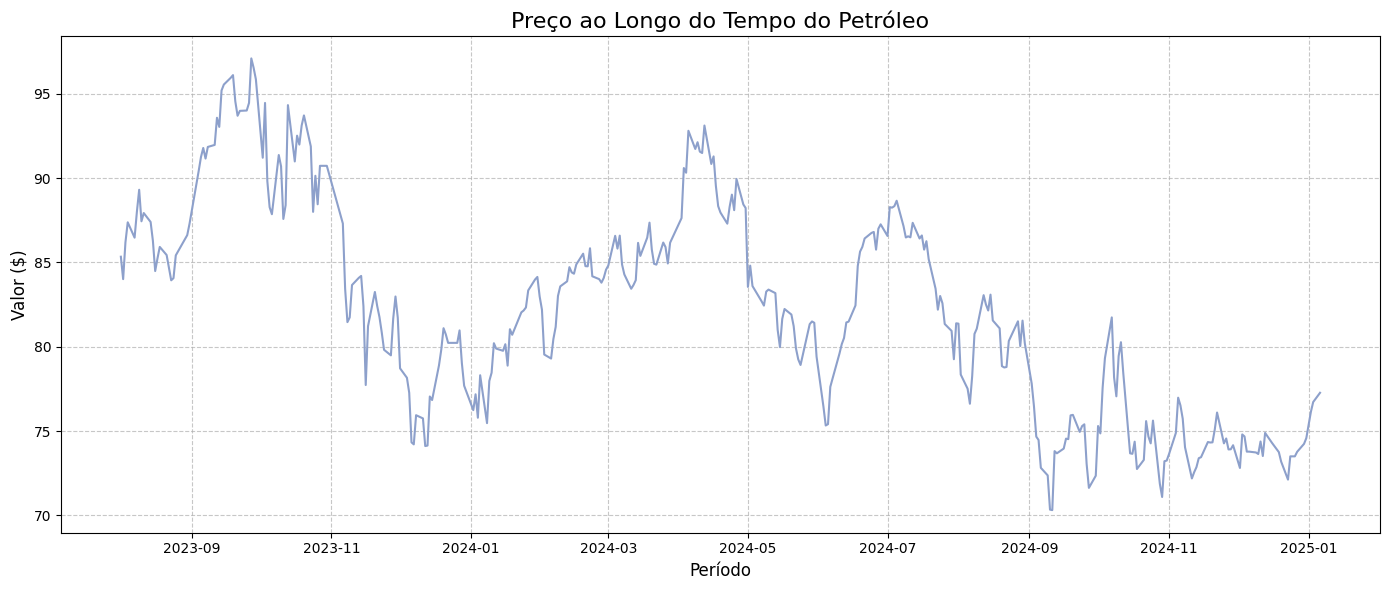

In [59]:
df_plot = df_base_ipea[df_base_ipea['data'] >= '2023-08-01']

plt.figure(figsize=(14,6)) 
medium_colors = sns.color_palette("Set2")

sns.lineplot(x='data', y='preco', color=medium_colors[2], data=df_plot)

plt.title('Preço ao Longo do Tempo do Petróleo', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valor ($)', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [60]:
df_prophet = df_base_ipea.rename(columns={'data': 'ds', 'preco': 'y'})
df_prophet = df_prophet[['ds','y']]
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet[df_prophet['ds'] >= '2023-08-01']

In [61]:
df_prophet['ano'] = df_prophet['ds'].dt.year
df_prophet['mes'] = df_prophet['ds'].dt.month
df_prophet['dia'] = df_prophet['ds'].dt.day
df_prophet['dia_semana'] = df_prophet['ds'].dt.weekday 
df_prophet = df_prophet[['ds', 'y', 'ano', 'mes', 'dia', 'dia_semana']]

Podemos observar, tanto pelo gráfico quanto pelas métricas de erro, que o modelo se adaptou muito melhor à base de treino mais recente. Isso ocorre porque, além da série temporal apresentar autocorrelação, a menor volatilidade dos dados nessa base facilita a captura de padrões pelo modelo. Como resultado, ele se torna menos complexo, reduzindo o risco de overfitting e melhorando sua capacidade de generalização na base de teste. Além disso, a redução do ruído na base de treino exige menos esforço do modelo para aprender os padrões corretos.

22:15:04 - cmdstanpy - INFO - Chain [1] start processing
22:15:04 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Prophet')

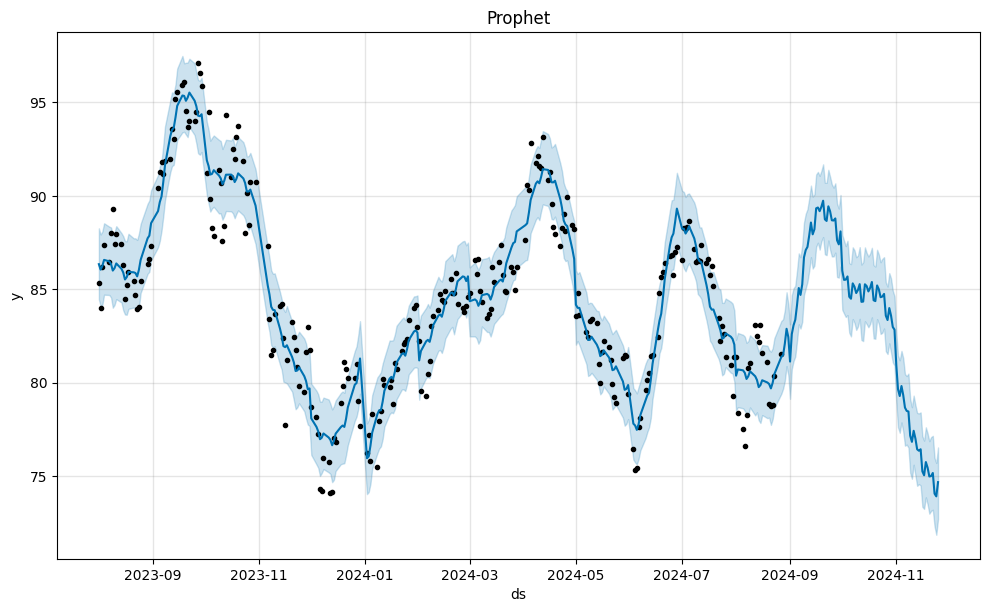

In [62]:
df_train = df_prophet.iloc[:-90]  
df_test = df_prophet.iloc[-90:]  

model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1  
)
model.add_regressor('ano')
model.add_regressor('mes')
model.add_regressor('dia')
model.add_regressor('dia_semana')

model.fit(df_train)

future = model.make_future_dataframe(periods=90)

future['ano'] = future['ds'].dt.year
future['mes'] = future['ds'].dt.month
future['dia'] = future['ds'].dt.day
future['dia_semana'] = future['ds'].dt.weekday

forecast_test = model.predict(future)


model.plot(forecast_test)
plt.title("Prophet")


In [63]:
predictions = forecast_test.iloc[-90:]['yhat']
metrics = calculate_metrics(df_test['y'], predictions)
print("Prophet Metrics:")
print_metrics(metrics)

Prophet Metrics:
MAE: 8.614999992491914
MSE: 93.74187947131655
MAPE: 11.59 %


# 5.0 Conclusão

## Análise Comparativa de Modelos de Previsão de Séries Temporais  

Neste trabalho, analisamos e comparamos diferentes modelos de previsão de séries temporais, incluindo **ARIMA, SARIMA, SARIMAX e Prophet**, com o objetivo de prever os preços do petróleo. Utilizamos uma abordagem meticulosa, levando em consideração tanto as **métricas quantitativas** quanto a **capacidade dos modelos de capturar tendências e padrões sazonais complexos**.  

---

### Principais Descobertas  

#### Modelos ARIMA/SARIMA/SARIMAX  
- **Eficácia**: Demonstraram ser eficazes na captura de padrões autoregressivos e de médias móveis, apropriados para séries temporais com características mais simples.  
- **Desempenho**: Mostraram-se sensíveis a ruídos e flutuações, o que dificultou o desempenho nesta base específica.  

#### Modelo Prophet  
- **Métricas**: Embora apresentasse métricas superiores, como **MAE, MSE e MAPE**, seu destaque foi a capacidade de capturar sazonalidades complexas e ajustar melhor os valores em séries temporais voláteis.  
- **Flexibilidade e Robustez**:  
  - Possui flexibilidade para incluir variáveis exógenas, como `ano`, `mês`, `dia` e `dia_da_semana`.  
  - Sua robustez em relação a outliers contribuiu para previsões mais realistas e precisas.  
- **Desempenho com Dados Recentes**:  
  - Observamos que, ao utilizar uma base de treino mais recente e com menos volatilidade (_após agosto de 2023_), o modelo Prophet apresentou melhor desempenho.  
  - A menor volatilidade facilita a captura de padrões e tendências, evitando a complexidade excessiva e o **overfitting**.  

---

### Conclusão Final  

Considerando tanto o desempenho quanto a capacidade dos modelos de lidar com a complexidade dos dados, o Prophet se mostrou a melhor opção para prever séries temporais mais instáveis. A combinação de análises quantitativas e qualitativas proporciona uma visão mais completa da modelagem de dados voláteis, gerando insights valiosos para aplicações futuras.

Além disso, os resultados indicam que usar dados mais recentes e estáveis pode melhorar significativamente a precisão das previsões. Reduzir a volatilidade e focar em períodos mais recentes ajuda o modelo a identificar padrões mais relevantes, tornando as previsões mais confiáveis.
